# Wine quality - Blackbox model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, average_precision_score, f1_score, precision_score, recall_score
from sklearn.tree import export_text
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, optimizers
from tensorflow.keras.models import load_model

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/wine-quality-dataset/WineQT.csv
/kaggle/input/wine-quality-dataset-red-white/winequality-white.csv
/kaggle/input/wine-quality-dataset-red-white/winequality-red.csv


I decided to frame the problem as a binary classification task: predicting whether a wine sample is of good or poor quality. The original dataset contains quality ratings ranging from 3 to 9, with the majority of wines rated 5 or 6. Wines with a score of 7 or higher were defined as good quality, while those rated below 7 were considered poor quality.

The red and white wine datasets were combined into a single dataset to increase the sample size and enable the model to learn from both wine types. A new binary feature was added to indicate wine type, where 0 represents red wine and 1 represents white wine.

Duplicate entries were removed prior to training to ensure that the model would not be influenced by repeated samples.

In [ ]:
# Load red wine data and label it as red (0)
df_red = pd.read_csv("/kaggle/input/wine-quality-dataset-red-white/winequality-red.csv", sep=";")
df_red["wine_type"] = 0  # red wine

# Load white wine data and label it as white (1)
df_white = pd.read_csv("/kaggle/input/wine-quality-dataset-red-white/winequality-white.csv", sep=";")
df_white["wine_type"] = 1  # white wine

# Combine the datasets
df_combined = pd.concat([df_red, df_white], ignore_index=True)

# Remove duplicate rows
df_combined = df_combined.drop_duplicates()

# Create binary target: 1 if quality >= 7 (good wine), else 0
df_combined["quality_binary"] = (df_combined["quality"] >= 7).astype(int)

In [ ]:
# Check class distribution of the binary target
print("Distribution of quality_binary (target variable):")
print(df_combined["quality_binary"].value_counts())

# Check distribution of wine types
print("\nDistribution of wine_type:")
print(df_combined["wine_type"].value_counts())

# Check distribution of quality values grouped by wine type
print("\nQuality distribution grouped by wine_type:")
print(df_combined.groupby(["wine_type", "quality"]).size())

Distribution of quality_binary (target variable):
quality_binary
0    4311
1    1009
Name: count, dtype: int64

Distribution of wine_type:
wine_type
1    3961
0    1359
Name: count, dtype: int64

Quality distribution grouped by wine_type:
wine_type  quality
0          3            10
           4            53
           5           577
           6           535
           7           167
           8            17
1          3            20
           4           153
           5          1175
           6          1788
           7           689
           8           131
           9             5
dtype: int64


### Addressing class imbalance

The current dataset has several imbalance issues that could negatively affect model performance:

- There are approximately four times more poor quality wines than good quality ones.
- The dataset contains nearly three times more white wine samples than red wine samples.
- A large proportion of the samples have a quality rating of 5 or 6. Since a rating of 6 is close to the threshold for "good quality," these samples may not differ significantly from the higher-quality group.

To address these imbalances, I decided to apply downsampling: I kept 500 samples from red wines rated 5 or 6, and 800 samples from white wines with the same ratings.

In [ ]:
# Helper function to keep only a limited number of samples with a specific quality value
def sample_specific_quality(df, wine_type_val, quality_val, n_to_keep):
    # Select subset to be undersampled
    df_sub = df[(df["wine_type"] == wine_type_val) & (df["quality"] == quality_val)]

    # Select the rest of the dataset (not undersampled)
    df_rest = df[~((df["wine_type"] == wine_type_val) & (df["quality"] == quality_val))]

    # Randomly sample the specified number of rows
    df_sampled = df_sub.sample(n=n_to_keep, random_state=42)

    # Concatenate and return the modified dataset
    return pd.concat([df_rest, df_sampled], ignore_index=True)

# Undersample red wines

# Keep only 500 samples of red wines with quality 5
df_combined = sample_specific_quality(df_combined, wine_type_val=0, quality_val=5, n_to_keep=500)
# Keep only 500 samples of red wines with quality 6
df_combined = sample_specific_quality(df_combined, wine_type_val=0, quality_val=6, n_to_keep=500)

# Undersample white wines

# Keep only 800 samples of white wines with quality 5
df_combined = sample_specific_quality(df_combined, wine_type_val=1, quality_val=5, n_to_keep=800)
# Keep only 800 samples of white wines with quality 6
df_combined = sample_specific_quality(df_combined, wine_type_val=1, quality_val=6, n_to_keep=800)

# Check class distribution of the binary target
print("Distribution of quality_binary (target variable):")
print(df_combined["quality_binary"].value_counts())

# Check distribution of wine types
print("\nDistribution of wine_type:")
print(df_combined["wine_type"].value_counts())

# Check distribution of quality values grouped by wine type
print("\nQuality distribution grouped by wine_type:")
print(df_combined.groupby(["wine_type", "quality"]).size())

Distribution of quality_binary (target variable):
quality_binary
0    2836
1    1009
Name: count, dtype: int64

Distribution of wine_type:
wine_type
1    2598
0    1247
Name: count, dtype: int64

Quality distribution grouped by wine_type:
wine_type  quality
0          3           10
           4           53
           5          500
           6          500
           7          167
           8           17
1          3           20
           4          153
           5          800
           6          800
           7          689
           8          131
           9            5
dtype: int64


## Creating a blackbox model

I created a neural network as the blackbox model. The dataset was prepared by removing the target columns (quality and quality_binary) and performing feature selection, excluding two features (residual sugar and free sulfur dioxide) which showed minimal correlation with wine quality.

The dataset was then split into training, testing and validation sets with an 80/10/10 ratio, using stratified sampling to preserve the class distribution of good and poor quality wines. Feature normalization was then applied to the continuous variables, while the binary wine_type feature was left unscaled.

In [ ]:
# Split features and target
X = df_combined.drop(columns=["quality", "quality_binary"])  # Drop raw target columns
X = X.drop(columns=["residual sugar", "free sulfur dioxide"])  # Feature selection
y = df_combined["quality_binary"]  # Use binary target

# First split: Train (80%) and Temp (20%) for val + test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Normalize features

continuous_features = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "chlorides",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]

categorical_features = [
    "wine_type"
]

# Avoid scaling wine_type
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_features),
        ("cat", "passthrough", categorical_features)
    ]
)

# Fit on training data and transform all sets accordingly
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

After experimenting with several neural network configurations, the architecture described below demonstrated the best performance on the binary wine quality classification task. The final model is a fully connected feed-forward neural network composed of four layers. The architecture integrates batch normalization to stabilize and accelerate training, LeakyReLU activation function to reduce the dying ReLU problem, and dropout (with a rate of 0.2) for regularization. The output layer consists of a single neuron with a sigmoid activation function, which outputs a probability and is appropriate for binary classification tasks.

The model is compiled using the Adam optimizer with a learning rate of 0.001. The binary crossentropy loss function is used, which is standard for binary classification problems. Model performance is evaluated using accuracy as the primary metric.

To prevent overfitting and reduce unnecessary training epochs, early stopping is applied. The validation loss is monitored during training, and if it does not improve over 10 consecutive epochs, training is halted and the best-performing model weights are restored automatically.

In [ ]:
# Define the neural network architecture
model = models.Sequential([
    layers.Dense(128, input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.01),
    layers.Dropout(0.2),

    layers.Dense(64),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.01),
    layers.Dropout(0.2),

    layers.Dense(32),
    layers.LeakyReLU(alpha=0.01),

    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Fit the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7205 - loss: 0.5373 - val_accuracy: 0.8125 - val_loss: 0.4658
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7927 - loss: 0.4357 - val_accuracy: 0.8177 - val_loss: 0.4201
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8064 - loss: 0.4106 - val_accuracy: 0.8333 - val_loss: 0.4120
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7907 - loss: 0.4279 - val_accuracy: 0.8177 - val_loss: 0.4071
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7945 - loss: 0.4114 - val_accuracy: 0.8125 - val_loss: 0.4042
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7960 - loss: 0.4186 - val_accuracy: 0.7995 - val_loss: 0.4007
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8052 - loss: 0.4066 - val_accuracy: 0.8099 - val_loss: 0.4073
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7939 - loss: 0.4114 - val_accuracy: 0.8073 - val_loss: 0.

In [ ]:
# Save the best model
model.save("/kaggle/working/wine_quality_model.keras")

## Evaluating the Blackbox Model

### Metrics Computed
- **Confusion Matrix:** Shows counts of true positives, false positives, true negatives, and false negatives.
- **Accuracy:** Overall correctness of the model.
- **Sensitivity / Recall (True Positive Rate):** Ability of the model to identify positive cases.
- **Specificity (True Negative Rate):** Ability of the model to identify negative cases.
- **Precision (Positive Predictive Value):** Proportion of positive identifications that are correct.
- **F1 Score:** Harmonic mean of precision and recall, balancing the two.

### Visualizations
- **ROC Curve and AUROC:** Plots the tradeoff between true positive rate and false positive rate
- **Precision-Recall Curve and AUPR:** Plots precision vs recall across thresholds

The neural network outperformed the decision tree across all evaluation metrics. It achieved an overall test accuracy of 81%, indicating solid general performance. The model's sensitivity was 63.4%, reflecting a moderate improvement in correctly identifying good quality wines. Specificity was notably high at 87.3%, reflecting the model’s strong performance in recognizing poor quality samples. The precision for predicting good quality wines was 64%, which still indicates limitations in this class.

The ROC curve further illustrates the neural network’s ability to distinguish between good and poor quality wines. The area under the ROC curve (AUROC) is 0.864, indicating a strong discriminative capability. This represents a noticeable improvement over the decision tree’s AUROC of 0.758, suggesting that the neural network is more reliable in classifying the wines.

The precision-recall curve shows a few small drops, but overall it follows a regular pattern. The area under the precision-recall curve (AUPR) is 0.690 which is still a modest value but is significantly better than the decision tree’s AUPR of 0.531. This improvement indicates that the neural network handles the positive class more effectively.

In [ ]:
# Load the model
model = load_model("/kaggle/working/wine_quality_model.keras")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Confusion Matrix:
[[248  36]
 [ 37  64]]
Accuracy: 0.810
Sensitivity / Recall (True Positive Rate): 0.634
Specificity (True Negative Rate): 0.873
Precision (Positive Predictive Value): 0.640
F1 Score: 0.637


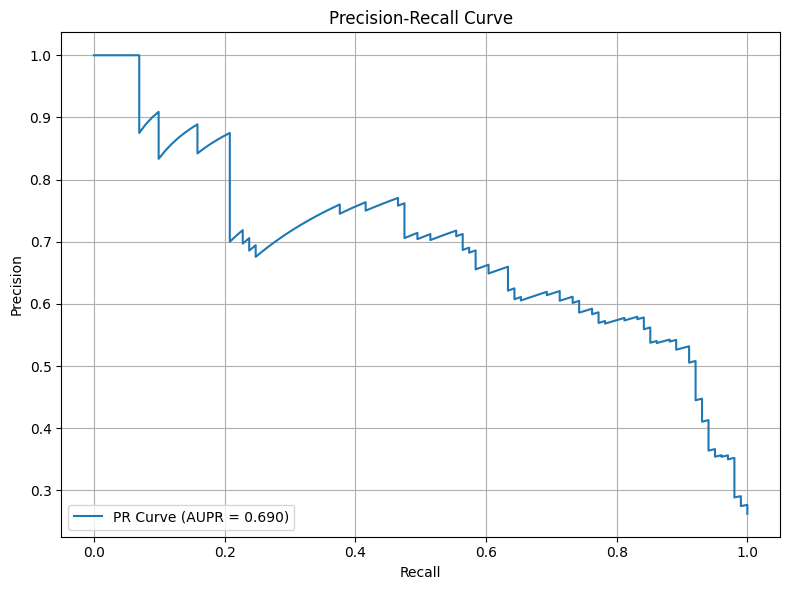

In [ ]:
# Predict probabilities for ROC and PR curve
y_prob = model.predict(X_test_scaled)

# Predict class labels
y_pred = (y_prob >= 0.5).astype(int)

# Confusion matrix and derived metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity / Recall (True Positive Rate): {recall:.3f}")
print(f"Specificity (True Negative Rate): {specificity:.3f}")
print(f"Precision (Positive Predictive Value): {precision:.3f}")
print(f"F1 Score: {f1:.3f}")

# ROC curve and AUROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUROC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# Precision-Recall curve and AUPR
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_vals, precision_vals)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f"PR Curve (AUPR = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.tight_layout()
plt.show()



## Local Interpretable Model-Agnostic Explanations (LIME)

For the LIME explanation, I selected four wine samples with quality ratings of 3, 5, 7, and 9 for detailed inspection.

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
# List of continuous features
continuous_features = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "chlorides",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]

# List of categorical features
categorical_features = [
    "wine_type"
]

# Full list of feature names
feature_names = continuous_features + categorical_features

# Mapping for categorical values to their readable names
categorical_names = {
    feature_names.index("wine_type"): ["red", "white"]
}

# Indexes of categorical features
categorical_features_idx = [feature_names.index(col) for col in categorical_features]

# Initialize the LIME tabular explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.to_numpy(),
    feature_names=feature_names,
    class_names=['Poor quality', 'Good quality'],
    categorical_features=categorical_features_idx,
    categorical_names=categorical_names,
    mode="classification",
    kernel_width=3,
    verbose=True
)

In [ ]:
# Wrapper function to make predictions in the format LIME expects
def predict_nn(input_array):

    # Convert input array to DataFrame so we can apply the same preprocessing
    df_input = pd.DataFrame(input_array, columns=X_train.columns)

    # Apply the same preprocessing as used during training
    X_processed = preprocessor.transform(df_input)

    # Get model predictions
    pred = model.predict(X_processed, verbose=0)

    # Stack predictions for both classes
    pred_stacked = np.hstack([1 - pred, pred])

    return pred_stacked

### Wine rated 3
The model incorrectly predicted it as good quality with a probability of 53%, despite 3 is the lowest rating in the database. The strongest factor influencing the prediction was the low volatile acidity, which the model heavily associated with good wine.

### Wine rated 5
The model correctly predicted poor quality with high confidence (95% probability). The strongest contributors to this decision were high volatile acidity, high chlorides, and relatively low alcohol content.

### Wine rated 7
The model incorrectly predicted poor quality with a probability of 68%, even though a rating of 7 marks the threshold for good wine. Most features contributed positively, such as low volatile acidity and low chlorides, but their combined influence was not enough to shift the prediction toward good quality. However, since this is a borderline case, some uncertainty in classification is expected.

### Wine rated 9
The model correctly predicted good quality with a high probability of 83%, aligning with the rating of 9. The most influential feature was high alcohol content, which contributed strongly toward a good classification, along with low chlorides. Almost all the features in this case are consistent with a high quality wine, and the model appropriately weighted them. This suggests the model is effective at recognizing strong, unambiguous signals of good wine.

From the examples, we can see that the model tends to associate white wines with higher quality than red wines. This may be due to an imbalance in the training data, where good quality white wines were more frequent than good quality red wines. As a result, the model may have learned a subtle bias.

In [ ]:
# Collect one sample for each quality score (3, 5, 7, 9)
selected_qualities = [3, 5, 7, 9]
selected_instances = []

for q in selected_qualities:
    sample = df_combined[df_combined["quality"] == q].sample(1, random_state=42)
    selected_instances.append(sample)

# Loop through each sample and explain with LIME
for sample_df in selected_instances:
    # Extract index and original quality
    quality_score = int(sample_df["quality"].values[0])

    # Drop original target columns to get features only
    sample_features = sample_df.drop(columns=["quality", "quality_binary", "residual sugar", "free sulfur dioxide"])

    # Make sure the column order matches X_train
    sample_features = sample_features[X_train.columns]

    # Convert to NumPy array for LIME
    inst = sample_features.to_numpy()[0]

    # Run explanation
    exp = explainer.explain_instance(inst, predict_nn, num_features=10, num_samples=10000)

    # Show explanation
    print(f"\n===== LIME Explanation for Wine Rated {quality_score} =====")
    exp.show_in_notebook(show_all=True)


Intercept 0.1248624515025483
Prediction_local [0.32181609]
Right: 0.52994484

===== LIME Explanation for Wine Rated 3 =====


Intercept 0.2808826645448514
Prediction_local [-0.07718219]
Right: 0.045454636

===== LIME Explanation for Wine Rated 5 =====


Intercept 0.1228274667717883
Prediction_local [0.32574994]
Right: 0.32197303

===== LIME Explanation for Wine Rated 7 =====


Intercept 0.05425184649835549
Prediction_local [0.53041112]
Right: 0.8349331

===== LIME Explanation for Wine Rated 9 =====


## Shaply Value Sampling (SHAP)

I calculated the Shapley values for the first 200 wines in the test set and examined two specific samples: one poor quality wine and one good quality wine.

In [ ]:
import shap

# Define SHAP explainer
explainer_shap = shap.SamplingExplainer(predict_nn, shap.sample(X_train, 1000, random_state=42))

In [ ]:
# Compute the SHAP values
shap_values = explainer_shap.shap_values(X_test.iloc[:200, :], nsamples=1000, random_state=42)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Poor quality wine sample

index_to_plot = 1

# Get SHAP values for good quality class
shap_values_class1 = shap_values[1]

# Initialize the JS visualizer
shap.initjs()

# Plot force plot for one instance
shap.force_plot(
    explainer_shap.expected_value[1],
    shap_values_class1[index_to_plot],
    X_test.iloc[index_to_plot],
    feature_names=X_test.columns
)


The predicted value for the poor quality sample is 0.09, which is significantly lower than the base value of 0.2888. This indicates that the model predicts this sample to be of lower quality, which is correct. According to the SHAP values, alcohol had a large negative contribution to the prediction. Sulphates and chlorides also contributed negatively, further lowering the predicted value.

In [ ]:
# Good quality wine sample

index_to_plot = 3

# Get SHAP values for good quality class
shap_values_class1 = shap_values[1]

# Initialize the JS visualizer
shap.initjs()

# Plot force plot for one instance
shap.force_plot(
    explainer_shap.expected_value[1],
    shap_values_class1[index_to_plot],
    X_test.iloc[index_to_plot],
    feature_names=X_test.columns
)


For the good quality wine sample, the model predicted a value of 0.47, which is much higher than the base value. This suggests that the model correctly identifies this sample to be of higher quality. Most features contributed positively to good quality, with alcohol and total sulfur dioxide having the strongest influence.

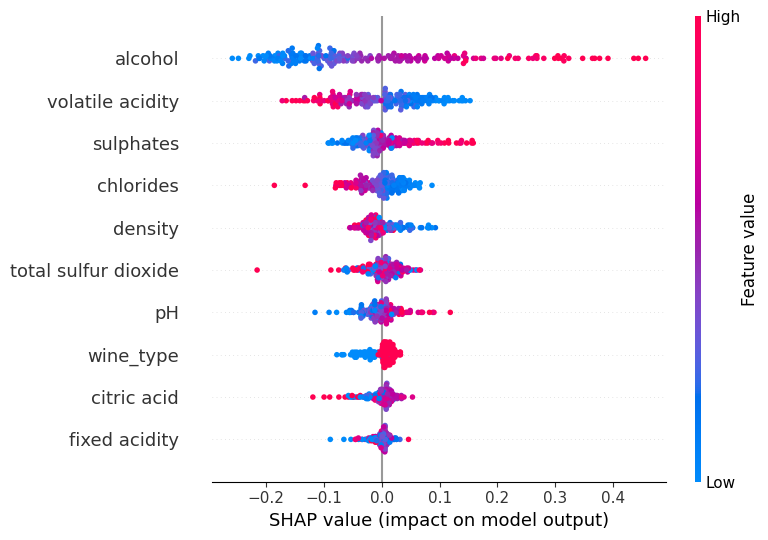

In [ ]:
# Summary of SHAP
shap.summary_plot(shap_values_class1, X_test.iloc[:200, :], feature_names=X_test.columns)

The diagram above illustrates the impact of each feature on the SHAP values, indicating their contribution to the model’s wine quality predictions.

- **Alcohol** has the strongest influence on predictions, consistent with earlier observations. Higher alcohol levels are associated with higher quality predictions, while lower levels reduce the predicted quality.  
- **Volatile acidity** is the second most impactful feature. Higher values of volatile acidity tend to negatively impact predicted quality, whereas lower values are associated with higher quality. This also aligns with earlier analysis.  
- **Sulphates** rank third in importance. Higher sulphate levels typically have a positive effect on predicted quality, while lower levels decrease it.  
- **Chlorides** show a negative correlation with predicted quality: wines with higher chloride levels are generally predicted to be of lower quality.  
- **Density** is mostly associated with negative contributions to quality. Higher density values reduce the predicted quality in most cases.  
- **Total sulfur dioxide** does not show a clear pattern and appears to have a highly variable effect. This is somewhat surprising, as in my earlier analysis I observed that total sulfur dioxide had a clearly negative impact on wine quality.
- **pH** tends to have a mostly positive correlation with predicted quality, though the impact is not as strong as the previous features.  
- **Wine type** (white vs. red) shows a slight bias: white wines are generally predicted to have higher quality.  
- **Citric acid** and **fixed acidity** do not show consistent trends.